<a href="https://colab.research.google.com/github/shoboske/wine-quality-deep-learning/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install ucimlrepo scikit-learn pandas numpy matplotlib tensorflow

In [2]:
from ucimlrepo import fetch_ucirepo
import numpy as np
from sklearn.model_selection import train_test_split

# fetch dataset
wine_quality = fetch_ucirepo(id=186)
red_wine = wine_quality.data.original.query('color == "red"')
white_wine = wine_quality.data.original.query('color == "white"')

columns_to_drop = ['quality', 'color']

# print(wine_quality.data.features)

X_red = red_wine.drop(columns=columns_to_drop)
y_red = red_wine['quality']

X_white = white_wine.drop(columns=columns_to_drop)
y_white = white_wine['quality']

In [73]:
import matplotlib.pyplot as plt

def plot_graph(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

Epoch 1/6000
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 293ms/step - accuracy: 0.1719 - loss: 2.8277 - mse: 34.1925 - learning_rate: 0.0100
Epoch 2/6000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4338 - loss: 1.8010 - mse: 33.8131 - learning_rate: 0.0100
Epoch 3/6000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4722 - loss: 1.3949 - mse: 33.6781 - learning_rate: 0.0100
Epoch 4/6000
 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5469 - loss: 1.0537 - mse: 35.7749

/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss,mse,learning_rate.
  callback.on_epoch_end(epoch, logs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.4849 - loss: 1.2580 - mse: 34.4465 - val_accuracy: 0.4592 - val_loss: 1.2812 - val_mse: 33.3299 - learning_rate: 0.0100
Epoch 5/6000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5445 - loss: 1.1056 - mse: 33.7369 - learning_rate: 0.0100
Epoch 6/6000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5233 - loss: 1.1172 - mse: 33.6674 - learning_rate: 0.0100
Epoch 7/6000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5449 - loss: 1.1275 - mse: 34.5346 - learning_rate: 0.0100
Epoch 8/6000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5527 - loss: 1.0612 - mse: 33.8819 - val_accuracy: 0.5765 - val_loss: 1.1584 - val_mse: 33.3330 - learning_rate: 0.0100
Epoch 9/6000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5582 - loss: 1.0741 - mse: 33.8380 - learning_rate: 0.0100
Epoch 10/6000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5441 - loss: 1.0897 - mse: 34.3737 - learning_rate: 0.0100
Epoch 11/6000


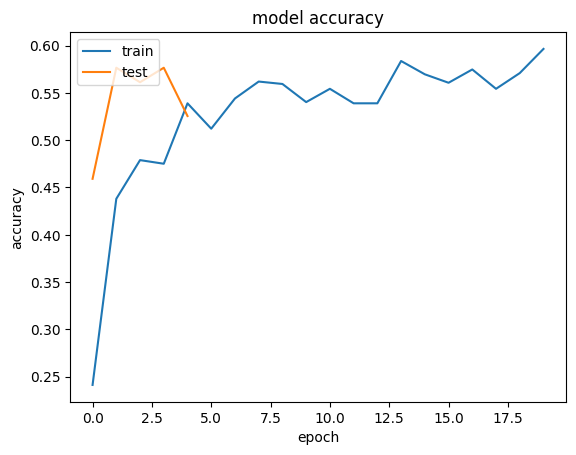

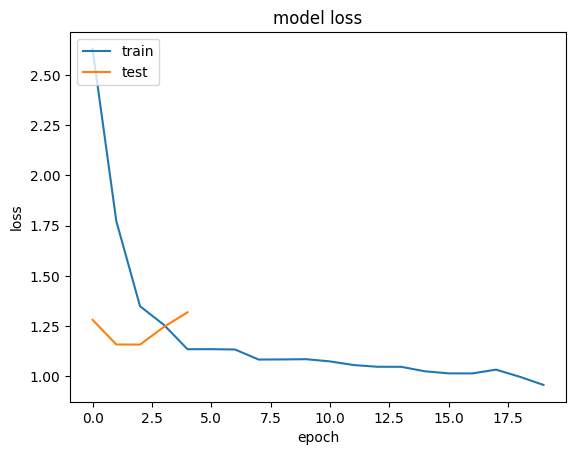

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import tensorflow as tf

# Split data into training and testing sets
X_red_train, X_red_test, y_red_train, y_red_test = train_test_split(X_red, y_red, test_size=0.8, random_state=42)
X_white_train, X_white_test, y_white_train, y_white_test = train_test_split(X_white, y_white, test_size=0.8, random_state=42)

# Create a Pipeline for feature selection and scaling
# Define the pipeline steps
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scaling
    ('selector', PCA(n_components=0.95))
])

# Fit and transform the pipeline on the training data (for both red and white wine)
X_red_train_processed = pipeline.fit_transform(X_red_train, y_red_train)
X_white_train_processed = pipeline.fit_transform(X_white_train, y_white_train)

# Transform the test data (for both red and white wine)
X_red_test_processed = pipeline.transform(X_red_test)
X_white_test_processed = pipeline.transform(X_white_test)

# Red Wine Model
red_wine_model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=X_red_train_processed.shape[1:]),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(80, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(11, activation='softmax')
    ],
     name="red-wine"
)

# White Wine Model (similar structure, adjust input shape)
white_wine_model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=X_white_train_processed.shape[1:]),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(80, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(80, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(80, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(80, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(80, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(80, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(80, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(11, activation='softmax')
    ],
    name="white-wine"
)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',  # Metric to monitor (e.g., validation loss)
    factor=0.5,          # Factor to reduce learning rate by (e.g., reduce by half)
    patience=5,          # Number of epochs with no improvement before reducing
    min_lr=0.00001      # Minimum learning rate allowed
)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

optimizer_red = tf.keras.optimizers.SGD(learning_rate=0.01)
optimizer_white = tf.keras.optimizers.Adam(learning_rate=0.01)

# Compile models (choose appropriate optimizer, loss, metrics)
red_wine_model.compile(optimizer=optimizer_red, loss=loss_fn, metrics=['accuracy'])
white_wine_model.compile(optimizer=optimizer_white, loss=loss_fn, metrics=['accuracy', 'mse'])

# Train the models
red_wine_model.fit(X_red_train_processed, y_red_train, epochs=6000, validation_split=0.1, validation_freq=10, callbacks=[callback], verbose=0)
history = white_wine_model.fit(X_white_train_processed, y_white_train, batch_size=64, epochs=6000, validation_split=0.2, validation_freq=4, callbacks=[callback, lr_scheduler], verbose=1)

plot_graph(history)

In [81]:
# Evaluate the model (you can use various metrics like accuracy, precision, recall, etc.)
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import pandas as pd

# Predictions for red and white wine
y_red_wine_pred = red_wine_model.predict(X_red_test_processed)  # Predictions for red wine
y_white_wine_pred = white_wine_model.predict(X_white_test_processed) # Predictions for white wine

# Convert predictions to class labels (if necessary)
y_red_wine_pred_classes = np.argmax(y_red_wine_pred, axis=1)
y_white_wine_pred_classes = np.argmax(y_white_wine_pred, axis=1)

# Evaluate Red Wine Model
accuracy_red = accuracy_score(y_red_test, y_red_wine_pred_classes)
recall_red = recall_score(y_red_test, y_red_wine_pred_classes, average='weighted', zero_division=0.0)
precision_red = precision_score(y_red_test, y_red_wine_pred_classes, average='weighted', zero_division=0.0)
f1_red = f1_score(y_red_test, y_red_wine_pred_classes, average='weighted')

# Evaluate White Wine Model
accuracy_white = accuracy_score(y_white_test, y_white_wine_pred_classes)
recall_white = recall_score(y_white_test, y_white_wine_pred_classes, average='weighted', zero_division=0.0)
precision_white = precision_score(y_white_test, y_white_wine_pred_classes, average='weighted', zero_division=0.0)
f1_white = f1_score(y_white_test, y_white_wine_pred_classes, average='weighted')

# Create data for DataFrame
data = [
    [f"{red_wine_model.name} ({', '.join(map(str, [*red_wine_model.layers[0].input.shape[1:], *[layer.units for layer in red_wine_model.layers if isinstance(layer, tf.keras.layers.Dense)]]))})", accuracy_red, recall_red, precision_red, f1_red],
    [f"{white_wine_model.name} ({', '.join(map(str, [*white_wine_model.layers[0].input.shape[1:], *[layer.units for layer in white_wine_model.layers if isinstance(layer, tf.keras.layers.Dense)]]))})", accuracy_white, recall_white, precision_white, f1_white]
]

headers = ["Model", "Accuracy", "Recall", "Precision", "F1 Score"]

# print(red_wine_model.summary())
# print(white_wine_model.summary())

print(pd.DataFrame(data, None, headers))

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
                                            Model  Accuracy    Recall  \
0                            red-wine (9, 80, 11)  0.330469  0.330469   
1  white-wine (9, 80, 80, 80, 80, 80, 80, 80, 11)  0.526155  0.526155   

   Precision  F1 Score  
0   0.418138  0.350020  
1   0.510766  0.512084  
